Load input. Normalized proteomics from CCLE was downloaded from [here](https://gygi.hms.harvard.edu/data/ccle/protein_quant_current_normalized.csv.gz) and normalized by Arjana Begzati using Perseus by downshift Gaussian distribution sampling. 

Metastatic potential was obtained from [Metmap 500](https://depmap.org/metmap/data/index.html).

In [1]:
import os
from tqdm import trange
from collections import Counter

import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import stats


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
seed = 42
data_path = '/home/hmbaghda/orcd/pool/metastatic_potential/'

In [4]:
mp = pd.read_excel(os.path.join(data_path, 'raw', 'Supplementary Table 04 MetMap 500 met potential.xlsx'), 
                   sheet_name = 'metp500.all5', index_col = 0)

md = pd.read_csv(os.path.join(data_path, 'raw', 'Model.csv'), index_col = 0)

expr = pd.read_csv(os.path.join(data_path, 'interim', 
                                'TableS2_PepNumbColsRemoved_80pSamplesMissingProtsRemoved_Imputed.csv'), 
                          index_col = None)


Format expression matrix:

In [5]:
# expr.drop(index = 0, inplace = True)
# expr.reset_index(inplace = True, drop = True)

expr.set_index('Protein_Id', inplace = True)
expr.drop(columns = ['Uniprot', '#Imputations'], inplace = True)

# drop samples repeated across templex
columns = ['_'.join(col.split('_')[:-1]) for col in expr.columns]
counts = Counter(columns)
duplicate_samples = [x for x in columns if counts[x] > 1]
print('{} non-unique samples across {} templexes are repeated and will be dropped'.format(len(set(duplicate_samples)), 
                                                                              len(duplicate_samples)))
duplicate_sample_ids = [col for col in expr.columns if '_'.join(col.split('_')[:-1]) in duplicate_samples]
expr.drop(columns = duplicate_sample_ids, inplace = True)

# format column names to match metastatic potential
expr.columns = ['_'.join(col.split('_')[:-1]) for col in expr.columns]
expr = expr.T


3 non-unique samples across 6 templexes are repeated and will be dropped


Retain overlapping samples between the expression nad metastatic potential dataset:

In [6]:
intersect_samples = sorted(set(expr.index).intersection(mp.index))
n_samples_expr_og = expr.shape[0]
print('{} samples overlap betwee the {} in the expression dataset and the {} in the metastatic potential dataset'.format(len(intersect_samples), expr.shape[0], mp.shape[0]))

mp = mp.loc[intersect_samples, :]
expr = expr.loc[intersect_samples, :]



248 samples overlap betwee the 372 in the expression dataset and the 488 in the metastatic potential dataset


Look at the data distributions:

In [7]:
stats_novst = pd.DataFrame({'mean': expr.mean(axis = 0), 'variance': expr.var(axis = 0)})
# stats_novst.reset_index(drop=True, inplace = True)

''

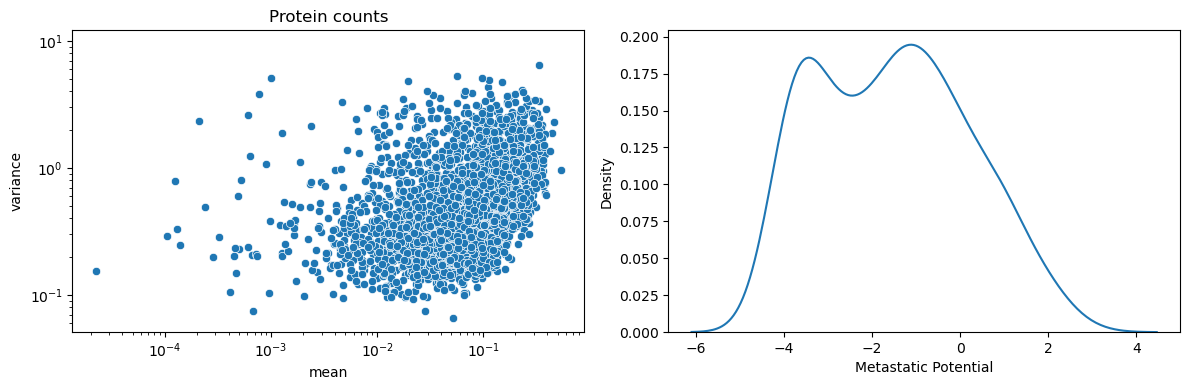

In [8]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 4))
ax = ax.flatten()

# subplot 1
i = 0
sns.scatterplot(data = stats_novst, x = 'mean', y = 'variance', ax = ax[i])
ax[i].set_xscale('log')
ax[i].set_yscale('log')
ax[i].set_title('Protein counts')

# subplot 4
i+=1
sns.kdeplot(data=mp, x='mean', ax = ax[i])
ax[i].set_xlabel('Metastatic Potential')

fig.tight_layout()
;

In [9]:
# get log of mean and variance
m = expr.mean(axis = 0)
v = expr.var(axis = 0, ddof = 1)

# fit lowess curve and get absolute residuals
y_fit = lowess(v, m, frac=0.3, return_sorted=False) 
resid = (v - y_fit).sort_values(ascending = False) # signed residuals -- high positive means more variance than expected

resid = pd.DataFrame(resid, columns = ['residual'])

# resid['mean'] = m_log
# resid['var'] = v_log
resid = pd.concat([resid,
           stats_novst.loc[resid.index, :]], axis = 1)

sr = stats.spearmanr(resid.residual, resid['mean']).statistic
print('The Spearman between expression mean and feature selection rank is: {:.3f}'.format(sr))
sr = stats.spearmanr(resid.residual, resid['variance']).statistic
print('The Spearman between expression variance and feature selection rank is: {:.3f}'.format(sr))


The Spearman between expression mean and feature selection rank is: -0.049
The Spearman between expression variance and feature selection rank is: 0.751


''

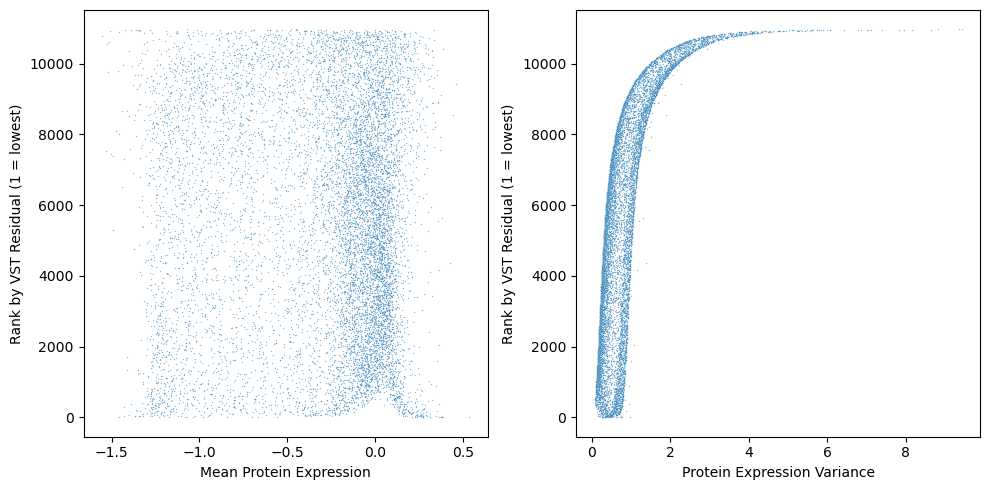

In [10]:
fig, ax = plt.subplots(ncols = 2, figsize = (10,5))

resid['feature_selection_rank'] = resid['residual'].rank(ascending=True)  # 1 = lowest CV

i = 0
sns.scatterplot(data=resid, x='mean', y='feature_selection_rank', alpha=0.5, s = 1, ax = ax[i])
ax[i].set_xlabel("Mean Protein Expression")
ax[i].set_ylabel("Rank by VST Residual (1 = lowest)")

i = 1
sns.scatterplot(data=resid, x='variance', y='feature_selection_rank', alpha=0.5, s = 1, ax = ax[i])
ax[i].set_xlabel("Protein Expression Variance")
ax[i].set_ylabel("Rank by VST Residual (1 = lowest)")

fig.tight_layout()
;

In [ ]:
mp.to_csv(os.path.join(data_path, 'processed', 'metastatic_potential_protein.csv'))
expr.to_csv(os.path.join(data_path, 'processed', 'expr_protein.csv'))